In [7]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from sympy.interactive import printing
import astropy.units as unit
from astropy.table import Table, QTable, Column
from os import listdir, rename
from scipy.integrate import solve_ivp
from scipy import integrate
plt.style.use('presentation.mplstyle')

## Values of velocity components from P2

In [8]:
u_av_lsr = -14.406535431539954
v_av_lsr = -11.347905033647525
w_av_lsr = -7.890709848641603

## Function for the numerical integration of suns future trajectory

In [10]:
def gal_orb(t, s): 
    '''A function describing the numerical integration properties with derived potentials. This outputs an 
    array of estimated values based on the initial conditions in terms of positions and motions of the 
    star(s) input.
    
    Parameters:
    ---------------
    t = time
    s = (x,y,z,u,v,w)
    
    '''
    # positional and mtional coordinates
    x, y, z = s[:3]*unit.pc
    u, v, w = s[3:]*unit.km/unit.s
    
    Ms = 1.12 * 10**(10)*unit.solMass 
    Md = 8.07 * 10**(10)*unit.solMass 
    G =  0.004301
    ad = 3700*unit.pc 
    bs = 277*unit.pc 
    bd = 200*unit.pc 
    rc = 6000*unit.pc 
    Mc = 5.0 * 10**(10)*unit.solMass 
    
    # Radius in cylindrical coordinates
    R = np.sqrt(x**2 + y**2)
    
    # Velocity components
    xdot = u 
    ydot = v
    zdot = w
    
    # Changing angles to dimnesionless
    angle = np.arctan(np.sqrt(x**2+y**2+z**2)/rc)
    angle = angle.to('', equivalencies=unit.dimensionless_angles()) 

    
    # Last three set of ODE equations in eq. (7.8) in Lecture notes
    dwdt = - G * z * (((Md * (ad + np.sqrt(bd**2 + z**2))) / (np.sqrt(bd**2 + z**2) * 
                    ((ad + np.sqrt(bd**2 + z**2))**2 + R**2)**(3/2))) + 
                      ((Ms ) / (((bs**2 + z**2 + R**2)**(3/2)))) +
                     Mc * ((1/(rc * (x**2+y**2+z**2)) - angle/(x**2+y**2+z**2)**(3/2))))
    dudt = - G * x * ((Md / ((R**2 + (ad + np.sqrt(z**2 + bd**2))**2)**(3/2))) + (Ms / ((R**2 + z**2 + bd**2)**(3/2))) +
                     Mc *((1/(rc * (x**2+y**2+z**2)) - angle/(x**2+y**2+z**2)**(3/2))))
    dvdt = - G * y * ((Md / ((R**2 + (ad + np.sqrt(z**2 + bd**2))**2)**(3/2))) + (Ms / ((R**2 + z**2 + bd**2)**(3/2))) +
                     Mc *((1/(rc * (x**2+y**2+z**2)) - angle/(x**2+y**2+z**2)**(3/2))))
    
    # parameters
    s = [u.value, v.value, w.value, dudt.value, dvdt.value, dwdt.value]
    
    return s
    
s0 = [-8000., 0, 0., u_av_lsr, 220 - v_av_lsr, w_av_lsr]  # initial conditions for the sun
t_span = [0,int(10000/0.9778)]
tid = np.linspace(t_span[0],t_span[1],100*t_span[1])
print(tid)
print(t_span)

# Performing the numerical integration
solsun = solve_ivp(gal_orb, t_span, s0, method='DOP853', t_eval = tid)
len(solsun.y)

[0.00000000e+00 1.00009805e-02 2.00019610e-02 ... 1.01979998e+02
 1.01989999e+02 1.02000000e+02]
[0, 102]
-8000.0 pc
-8000.000001244657 pc
-8000.000006546916 pc
-8000.000009820372 pc
-8000.000014730556 pc
-8000.0000350557075 pc
-8000.000041488546 pc
-8000.000031116414 pc
-8000.000038297121 pc
-8000.00008106219 pc
-8000.000074679347 pc
-8000.000106684732 pc
-8000.000124465488 pc
-8000.000124465488 pc
-8000.000012446569 pc
-8000.000024893134 pc
-8000.00009680653 pc
-8000.000189934404 pc
-8000.000222668722 pc
-8000.000271770234 pc
-8000.0004750196795 pc
-8000.000539347183 pc
-8000.000435627229 pc
-8000.000507433384 pc
-8000.000935075812 pc
-8000.0008712489225 pc
-8000.001191293985 pc
-8000.001369095507 pc
-8000.001369095507 pc
-8000.0020237609015 pc
-8000.002351079531 pc
-8000.0028420609915 pc
-8000.004874348789 pc
-8000.005517535818 pc
-8000.00448047282 pc
-8000.005198442855 pc
-8000.009474041706 pc
-8000.008835926498 pc
-8000.012035498843 pc
-8000.013812909902 pc
-8000.013812909902 pc
-

6

In [4]:
# Values obtained from the numerical integration
yvalues = solsun.y[1]
xvalues = solsun.y[0]
zvalues = solsun.y[2]
uvalues = solsun.y[3]
vvalues = solsun.y[4]
wvalues = solsun.y[5]

## Calculating Periods, oscillations and amplitudes

In [5]:
'''Calculating periods sun'''
rev = []
for i in range(1, len(uvalues)):
    if yvalues[i-1] < 0 and yvalues[i] > 0:
        rev.append(tid[i])
period_new = [rev[0]]
for i in range(1,len(rev)):
        period_new.append(rev[i] - rev[i-1])
Per_sun = np.mean(period_new)
print('Suns orbital period =',Per_sun, 'Myr')

Suns orbital period = 244.02682397622226 Myr


In [6]:
rad = np.sqrt(xvalues**2 + yvalues**2)
Av = 10  # Number of times averaging 
ab = np.gradient(rad)  # finding where data increase/decrease
aa = np.sign(ab)
li = []

# looping to find every peak
for i in range(len(aa)):
    if aa[i]*aa[i-1] < 0:
        li.append(i)
    elif aa[i]*aa[i-1] == 0:
        li.append(i)
        
# Sort values for averaging
li = li[0:Av+1]
for i,x in enumerate(li):
    if x < 2000:
        li.pop(i)
        
tpsun = tid[li[-1]]/(len(li)/2)
print('first peak = ', rad[li[0]])
print('fifth peak = ', rad[li[-1]])
print('sun epicycle period = ', tpsun, 'Myr')

first peak =  9117.175757287647
fifth peak =  7862.687109401265
sun epicycle period =  176.35817244370043 Myr


In [7]:
# Same procedure as for the periods
Average = 10
Ampz = 0.5*(max(zvalues)-min(zvalues))
print('Amplitude in z =',Ampz , 'pc')
gradz = np.diff(zvalues)
signz = np.sign(gradz)
listz = []
for i in range(len(signz)):
    if signz[i]*signz[i-1] < 0:
        if i > 1000:
            listz.append(i)
Perz = tid[listz[Average]]/((Average+1)/2)
print('period z = ' ,Perz, 'Myr')

Amplitude in z = 88.51609740490713 pc
period z =  66.74370162588495 Myr


## Plotting trajectory and properties for sun

[7862.47328654 9117.17576775  244.02682398  176.35817244   66.74370163
   88.5160974 ]


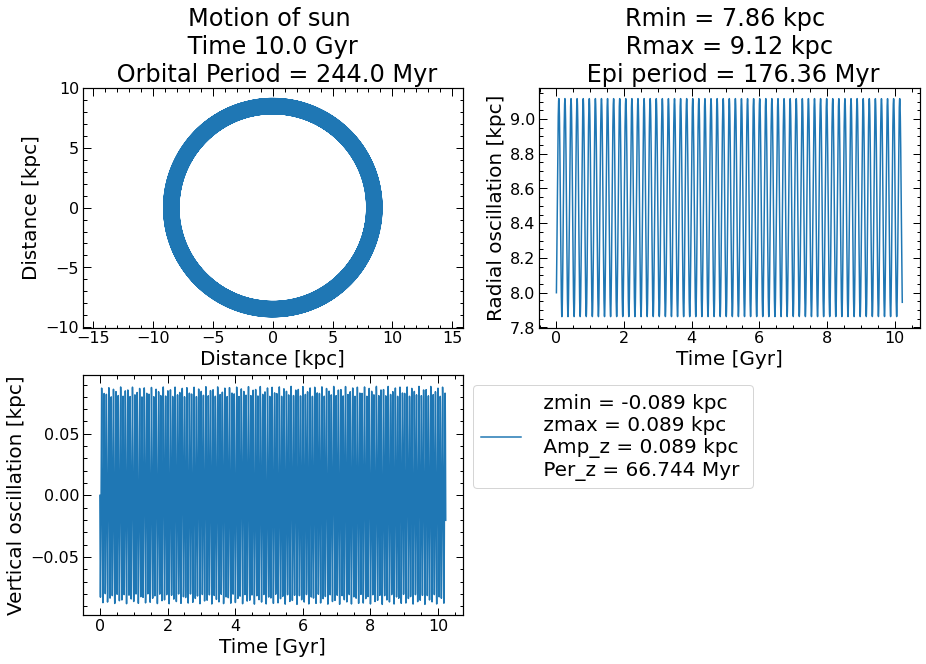

In [8]:
def calc_and_plot_sun(sol, xdata, ydata, Rdata, zdata, Amp, lendata, Porb, Pepi, Pz, plot = True):
    '''A function to plot and calculate properties of the sun. If plot=True, the output will display
    three plots for the sun: 
    1. Its future trajectory over 10 Gyr 
    2. The radial oscillation as a function of time
    3. The vertical oscillation as a function of time
    
    The function also outputs an array consisting of the calculated values for the pericentre, apocentre,
    orbital period, epicycle period, vertical amplitude and vertical period.
    
    Parameters:
    -----------
    sol = integration output
    xdata = xvalues from integration
    ydata = yvalues -||-
    zdata = zvalues -||-
    Rdata = radial values -||-
    Amp = Vertical amplitude
    lendata = number of values put in array
    Porb = Orbital period
    Pepi = epicycle period
    Pz = Vertical period
    '''
    
    if plot:
        fig = plt.figure(figsize = (15, 15))
        plt.subplot(321)
        plt.axis('equal')
        plt.title('Motion of sun \n Time {} Gyr \n Orbital Period = {} Myr'.format(np.around(0.0009778*t_span[1],2), np.around(Porb)))
        plt.xlabel('Distance [kpc]')
        plt.ylabel('Distance [kpc]')
        plt.plot(xdata/1000, ydata/1000)
        plt.subplot(322)
        plt.title('Rmin = {} kpc \n Rmax = {} kpc \n Epi period = {} Myr'.format(np.around(min(Rdata)/1000,2), np.around(max(Rdata)/1000,2),np.around(Pepi,2)))
        plt.ylabel('Radial oscillation [kpc]')
        plt.xlabel('Time [Gyr]')
        plt.plot(tid/1000, Rdata/1000)
        plt.subplot(323)
        plt.xlabel('Time [Gyr]')
        plt.ylabel('Vertical oscillation [kpc]')
        plt.plot(tid/1000, zdata/1000, label = ' zmin = {} kpc \n zmax = {} kpc \n Amp_z = {} kpc \n Per_z = {} Myr'.format(np.around(min(zdata)/1000,3), np.around(max(zdata)/1000,3), np.around(Amp/1000,3), np.around(Perz,3)))
        plt.legend(bbox_to_anchor=(1,1))
        plt.savefig('Suns-trajectory.png', dpi = 300, bbox_inches=('tight'))
        
    # Creating the output matrix 
    Values = np.zeros((lendata))
    Values[0] = min(Rdata)
    Values[1] = max(Rdata)
    Values[2] = Porb
    Values[3] = Pepi
    Values[4] = Pz
    Values[5] = Amp
        
    return Values
print(calc_and_plot_sun(solsun, xvalues, yvalues, rad, zvalues, Ampz, 6, Per_sun, tpsun, Perz))

In [9]:
# Choose 20 random stars from Hipparcos
import random
veldata = np.loadtxt('galvel.dat.txt', usecols = range(0,4))
randvel = random.sample(list(veldata), 20)
velocities = [randvel[i] for i in range(len(randvel))]

## Numerical integration of Hipparcos stars

The following cells are following the same procedure as for the calculations of the sun. The comments
applied on the previous cells hence applies below if nothing else is stated. 

In [10]:
def gal(t, s,): 
    '''A function describing the numerical integration properties with derived potentials. This outputs an 
    array of estimated values based on the initial conditions in terms of positions and motions of the 
    star(s) input.
    
    Parameters:
    ---------------
    t = time
    s = (x,y,z,u,v,w)
    
    '''
    # positional and mtional coordinates
    x, y, z = s[:3]*unit.pc
    u, v, w = s[3:]*unit.km/unit.s

    # Constants
    #Ms = 1.12*10**(10)*unit.solMass
    #Md = 8.07*10**(10)*unit.solMass
    #Mc = 5.0*10**(10)*unit.solMass
    #G =  0.004301
    #ad = 3700*unit.pc
    #bs = 277*unit.pc
    #bd = 200*unit.pc
    #rc = 6000*unit.pc
    #a_s = 0
    
    Ms = 1.12 * 10**(10)*unit.solMass 
    Md = 8.07 * 10**(10)*unit.solMass 
    G =  0.004301
    ad = 3700*unit.pc 
    bs = 277*unit.pc 
    bd = 200*unit.pc 
    rc = 6000*unit.pc 
    Mc = 5.0 * 10**(10)*unit.solMass 
    
    # Radius in cylindrical coordinates
    R = np.sqrt(x**2 + y**2)
    
    # Velocity components
    xdot = u 
    ydot = v
    zdot = w
    
    # Changing angles to dimnesionless
    angle = np.arctan(np.sqrt(x**2+y**2+z**2)/rc)
    angle = angle.to('', equivalencies=unit.dimensionless_angles()) 

    
    # Last three set of ODE equations in eq. (7.8) in Lecture notes
    dwdt = - G * z * (((Md * (ad + np.sqrt(bd**2 + z**2))) / (np.sqrt(bd**2 + z**2) * 
                    ((ad + np.sqrt(bd**2 + z**2))**2 + R**2)**(3/2))) + 
                      ((Ms ) / (((bs**2 + z**2 + R**2)**(3/2)))) +
                     Mc * ((1/(rc * (x**2+y**2+z**2)) - angle/(x**2+y**2+z**2)**(3/2))))
    dudt = - G * x * ((Md / ((R**2 + (ad + np.sqrt(z**2 + bd**2))**2)**(3/2))) + (Ms / ((R**2 + z**2 + bd**2)**(3/2))) +
                     Mc *((1/(rc * (x**2+y**2+z**2)) - angle/(x**2+y**2+z**2)**(3/2))))
    dvdt = - G * y * ((Md / ((R**2 + (ad + np.sqrt(z**2 + bd**2))**2)**(3/2))) + (Ms / ((R**2 + z**2 + bd**2)**(3/2))) +
                     Mc *((1/(rc * (x**2+y**2+z**2)) - angle/(x**2+y**2+z**2)**(3/2))))
    #dwdt = - G * z * (((Md * (ad + np.sqrt(bd**2 + z**2))) / (np.sqrt(bd**2 + z**2) * ((ad + np.sqrt(bd**2 + z**2))**2 + R**2)**(3/2))) + ((Ms * np.sqrt(bs**2 + z**2)) / (np.sqrt(bs**2 + z**2) * ((bs**2 + z**2 + R**2)**(3/2)))))    
    #dudt = - G * x * ((Md / ((R**2 + (ad + np.sqrt(z**2 + bd**2))**2)**(3/2))) + (Ms / ((R**2 + z**2 + bd**2)**(3/2))))
    #dvdt = - G * y * ((Md / ((R**2 + (ad + np.sqrt(z**2 + bd**2))**2)**(3/2))) + (Ms / ((R**2 + z**2 + bd**2)**(3/2))))
    
    s = [u.value, v.value, w.value, dudt.value, dvdt.value, dwdt.value]
    
    return s
t_span = [0,int(10000/0.9778)]    
s0 = [(-8000., 0, 0., velocities[i][1], 220 + velocities[i][2], velocities[i][3]) for i in range(len(velocities))]    
solsun1 = [solve_ivp(gal, t_span, s0[i], method='DOP853', t_eval = np.linspace(t_span[0],t_span[1],100*t_span[1])) for i in range(len(velocities))]

In [11]:
xlist = [solsun1[i].y[0] for i in range(len(velocities))]
ylist = [solsun1[i].y[1] for i in range(len(velocities))]
zlist = [solsun1[i].y[2] for i in range(len(velocities))]
Rlist = [np.sqrt(xlist[i]**2 + ylist[i]**2) for i in range(len(xlist))]
ulist = [solsun1[i].y[3] for i in range(len(velocities))]
vlist = [solsun1[i].y[4] for i in range(len(velocities))]
wlist = [solsun1[i].y[5] for i in range(len(velocities))]
timelist = np.linspace(0, t_span[1], len(Rlist[0]))

In [12]:
# Extracting the mean velocity components from the numerical integration
meanu, meanv, meanw = [], [], []
for i in ulist:
    meanu.append(np.mean(i))
for i in vlist:
    meanv.append(np.mean(i))
for i in wlist:
    meanw.append(np.mean(i))

In [13]:
'''New orbital periods'''
rev_all = []
for j in range(len(velocities)):
    revs = []
    for i in range(1, len(ylist[1])):
        if ylist[j][i-1] < 0 and ylist[j][i] > 0:
            revs.append(timelist[i])
    rev_all.append(revs)
period_new = []
mean_period = []
for j in range(len(velocities)):
    period_new = [rev_all[j][0]]
    for i in range(1,len(rev_all[j])):
            period_new.append(rev_all[j][i] - rev_all[j][i-1])
    mean_period.append(np.mean(period_new))
new_orbs = mean_period

In [14]:
Rgrad = [np.diff(Rlist[i]) for i in range(len(velocities))]
Rsign = [np.sign(Rgrad[i]) for i in range(len(velocities))]
idxlist = []
for i in range(len(Rsign)):
    qq = []
    for j in range(len(Rsign[i])):
        if Rsign[i][j]*Rsign[i][j-1]<0:
            if j > 2000:
                qq.append(j)
    idxlist.append(qq)

#Used such that averaging is possible
idxlength = []
for i in range(len(idxlist)):
    if len(idxlist[i]) == 0:
        continue
    else:
        idxlength.append(len(idxlist[i]))

#Epicycle periods
Periods = [tid[idxlist[i][min(idxlength)-1]]/((min(idxlength))/2) for i in range(len(velocities))]
print(Periods)


[130.15160552361087, 124.57333919959535, 162.00763667256084, 149.0651892347772, 177.62765194587197, 160.44606992826357, 133.7556090476194, 163.11494210311446, 158.68589429411358, 156.55458786228783, 153.677193744413, 165.66607503240468, 126.01577539262371, 172.60277746731296, 129.75960514031138, 155.53180425351044, 147.20188306500316, 151.14710431396003, 154.7380643469537, 156.88397948871608]


In [15]:
# Vertical periods and amplitudes
Averages = 10
zgrad = [np.diff(zlist[i]) for i in range(len(velocities))]
zsign = [np.sign(zgrad[i]) for i in range(len(velocities))]
zval = []
for i in range(len(zsign)):
    zz = []
    for j in range(len(zsign[i])):
        if zsign[i][j]*zsign[i][j-1]<0:
            if j > 1000:
                zz.append(j)
    zval.append(zz)
    
zidxlength = []
for i in range(len(zval)):
    zidxlength.append(len(zval[i]))

zPeriods = [tid[zval[i][Averages]]/((Averages+1)/2) for i in range(len(velocities))]
zAmplitudes = [0.5*(max(zlist[i]) - min(zlist[i])) for i in range(len(velocities))]
print(zAmplitudes)

[74.64878828980608, 275.19075037391303, 178.62719758875105, 85.95872894307706, 12.002330008142524, 150.3694871541477, 122.87508359734895, 83.08551956370752, 226.43232679811467, 321.72001028419123, 141.35260409274704, 43.986645347438525, 137.38986602952284, 191.8951244673981, 18.30042909906313, 159.25071129006312, 74.98241030374984, 162.21728669637912, 230.50080334386365, 102.53452961921145]


In [16]:
# Extracting orbital velocities
veldata = [np.mean(np.sqrt(ulist[i]**2 + vlist[i]**2 + wlist[i]**2))*unit.km/unit.s for i in range(len(velocities))]
radii = [np.mean((Rlist[i]*unit.pc).to(unit.km)) for i in range(len(velocities))]
TP = [((2*np.pi)*radii[i])/veldata[i] for i in range(len(velocities))]
orbPer = [TP[i].to(unit.Myr) for i in range(len(velocities))]

[106551.    4190.2   8605.3    186.1    130.2     48.1     74.6      0.1
     -0.4      0. ]
[22336.   3742.1  8423.1   179.    124.6    54.1   275.2     0.1     0.3
    -0. ]
[3330.  7408.4 8058.4  220.7  162.    64.6  178.6    1.1    0.7    0. ]
[69929.   6203.4  8187.4   205.1   149.1    54.9    86.      0.2    -0.3
    -0. ]
[14146.   7752.3  9130.9   242.4   177.6    64.5    12.      0.7     0.8
    -0. ]
[78970.   6910.7  8495.4   220.    160.4    62.1   150.4     1.5    -0.1
    -0. ]
[37504.   5074.7  8028.7   187.3   133.8    50.8   122.9     1.3    -0.2
     0. ]
[32489.   7253.   8405.9   223.7   163.1    60.5    83.1     0.9    -0.8
    -0. ]
[83962.   7196.7  8021.1   217.2   158.7    66.1   226.4     0.2     0.4
    -0. ]
[21421.   6162.6  8892.3   216.6   156.6    71.2   321.7     0.7     0.8
     0. ]
[70327.   6568.8  8305.6   212.1   153.7    59.6   141.4     0.5     0.8
    -0. ]
[62561.   7732.5  8145.9   226.6   165.7    60.3    44.      0.2     0.6
     0. ]
[1538

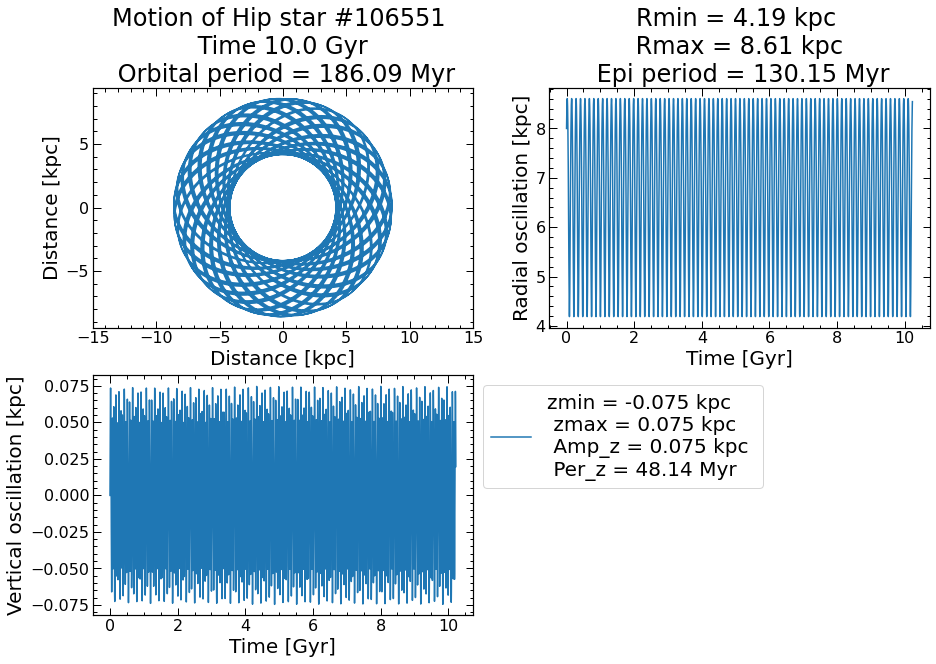

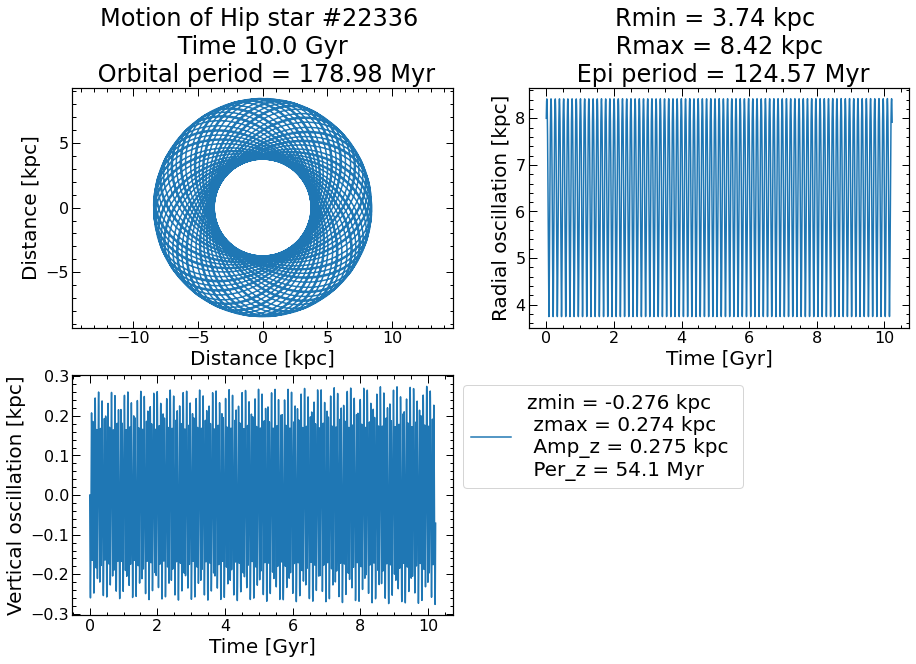

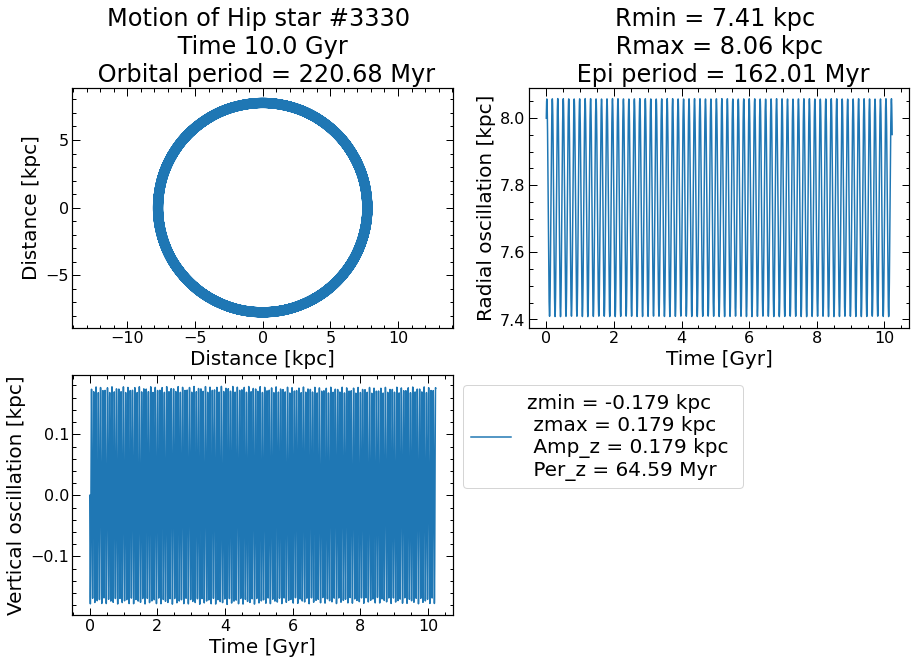

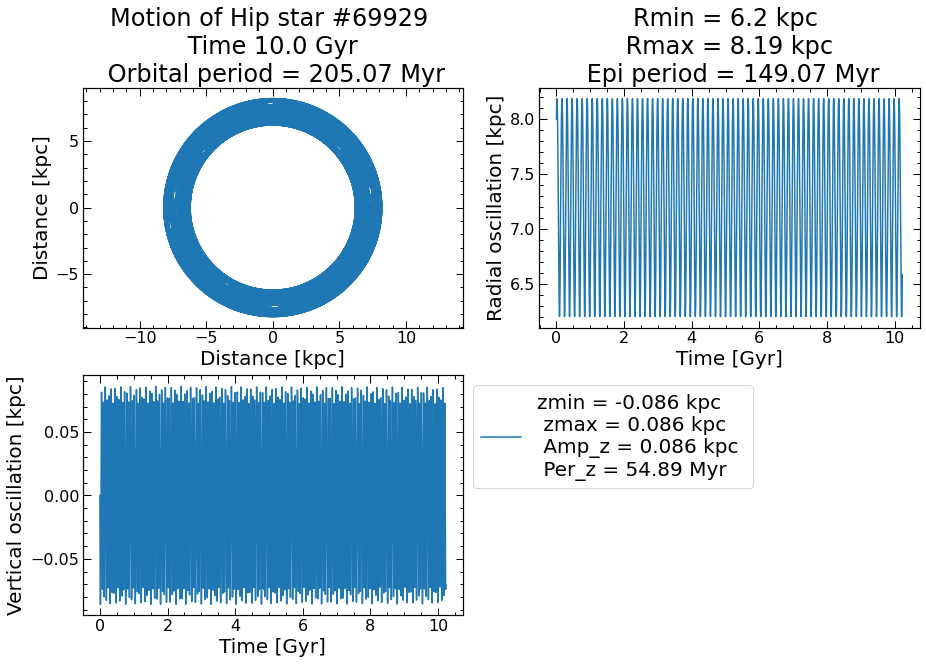

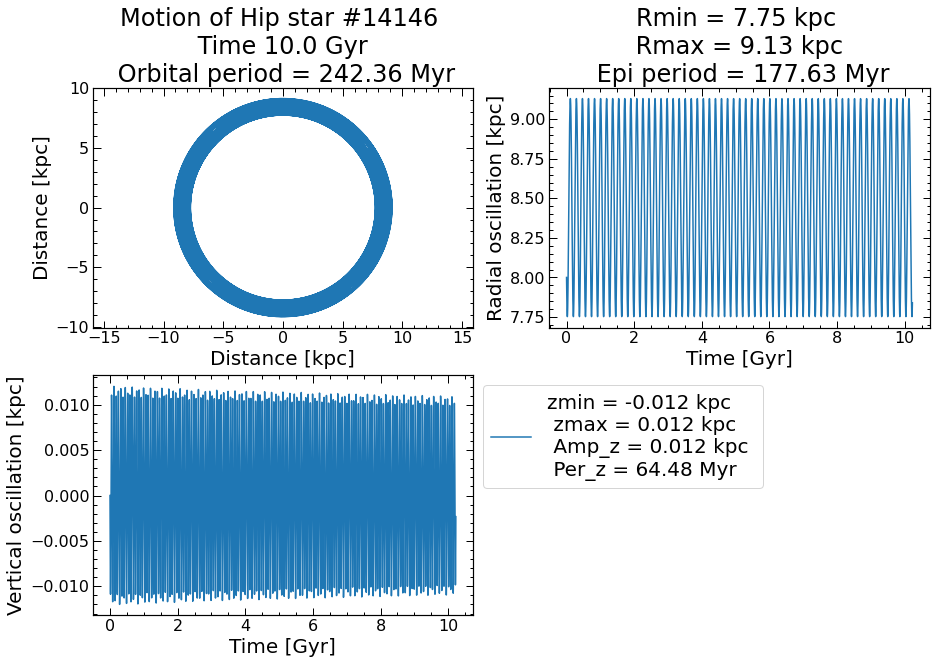

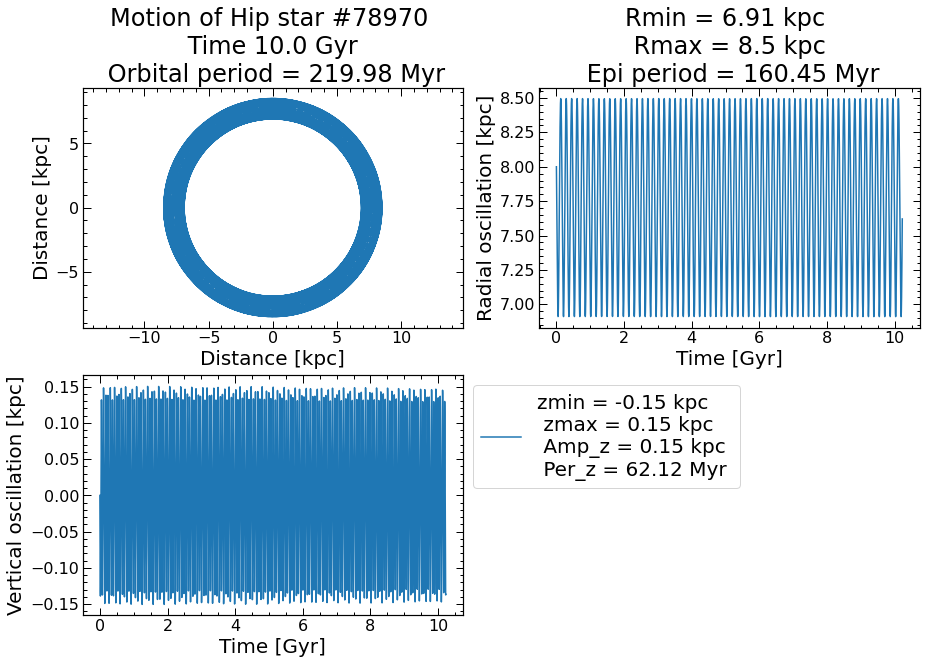

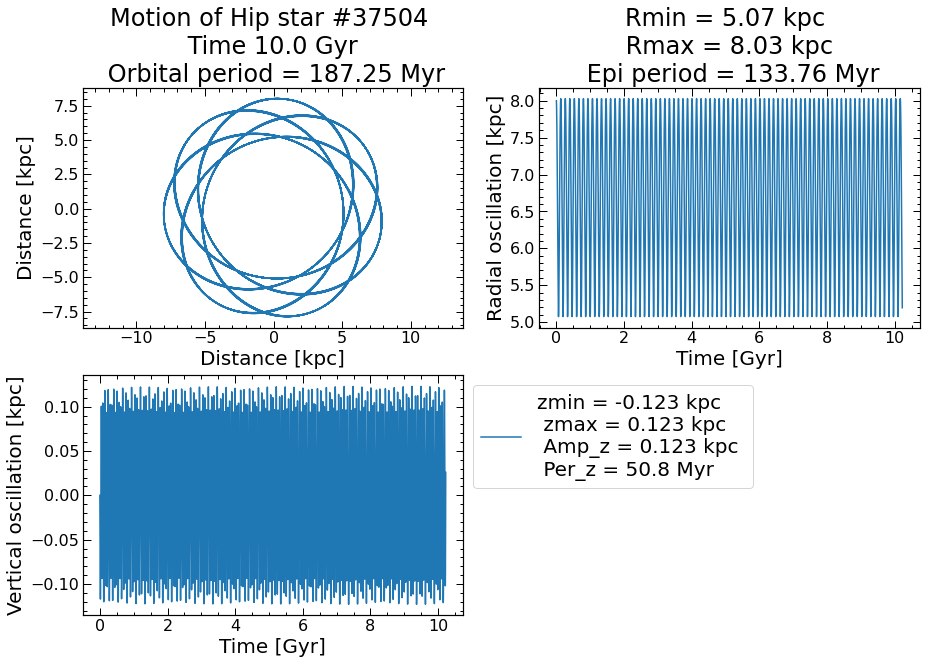

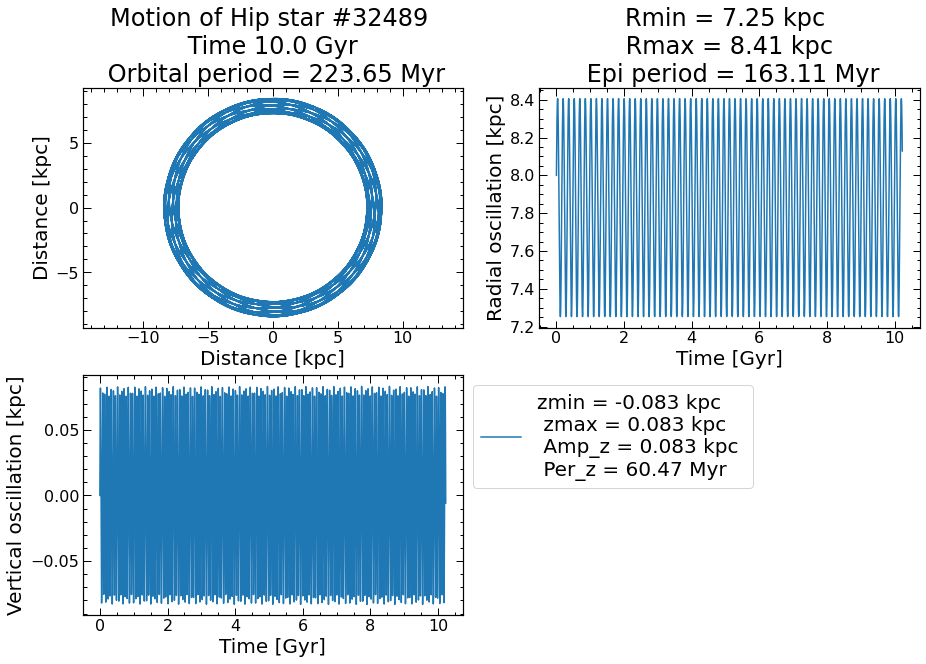

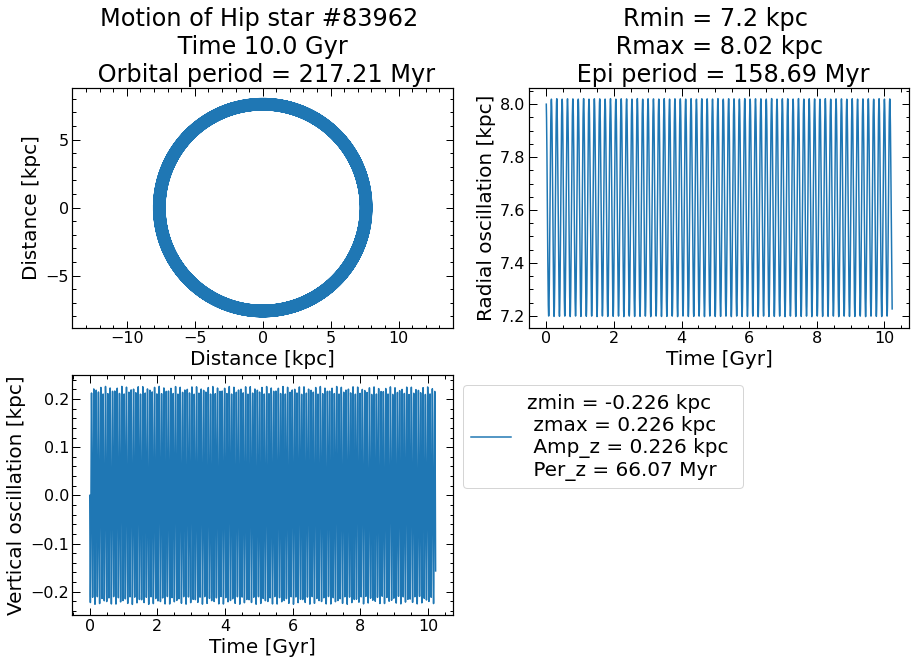

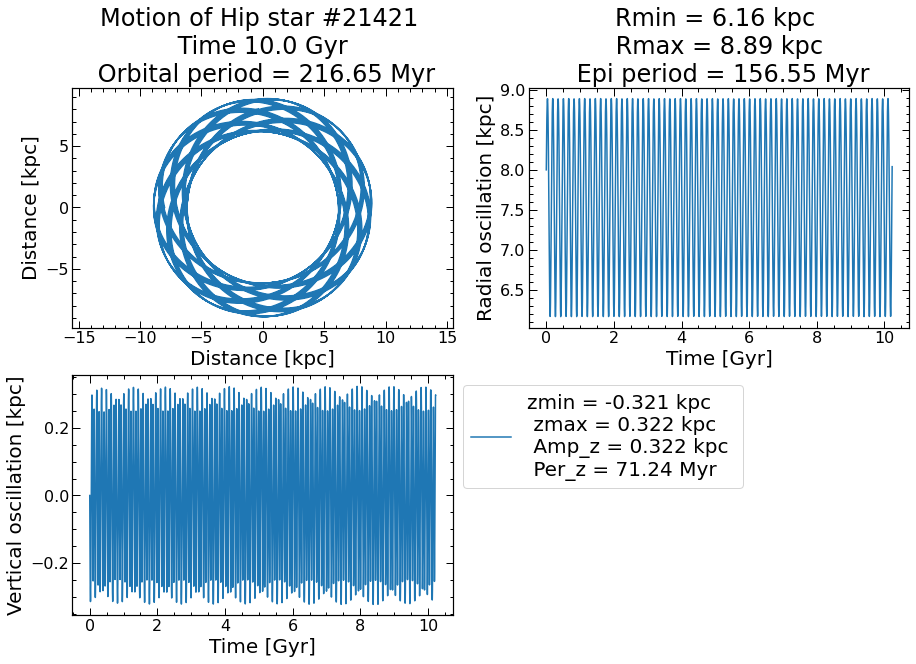

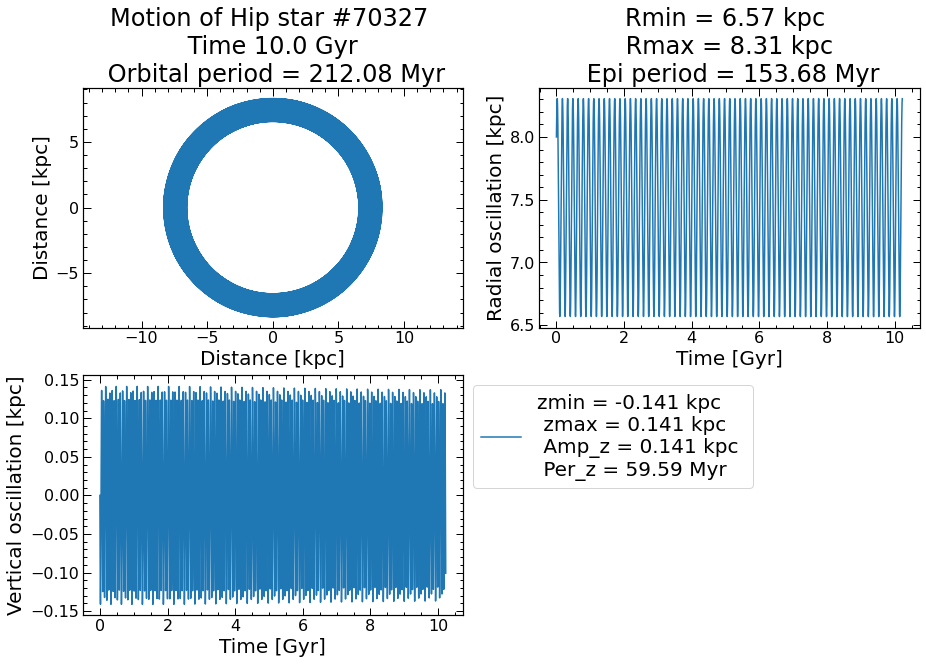

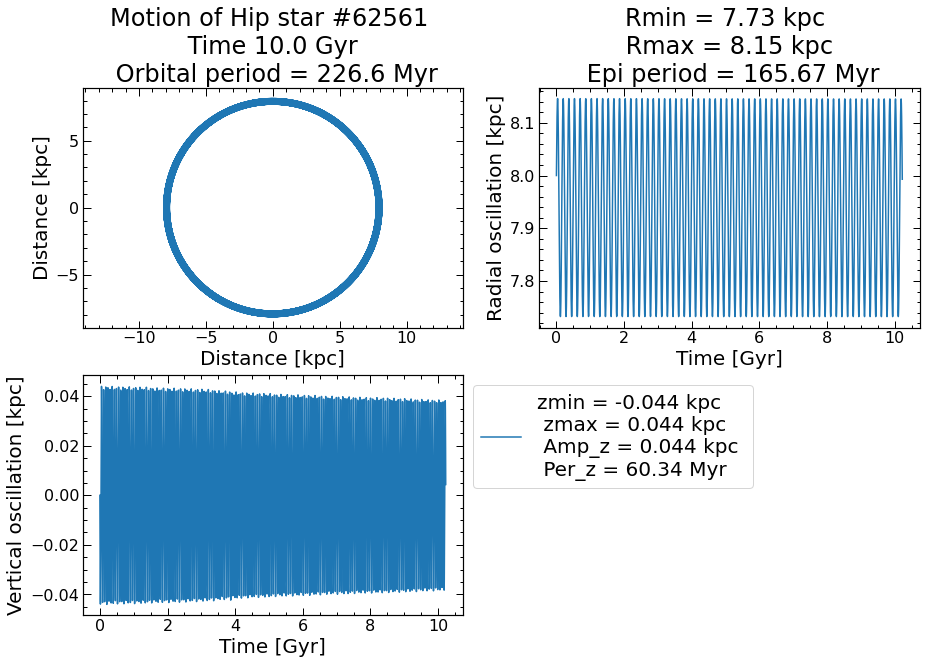

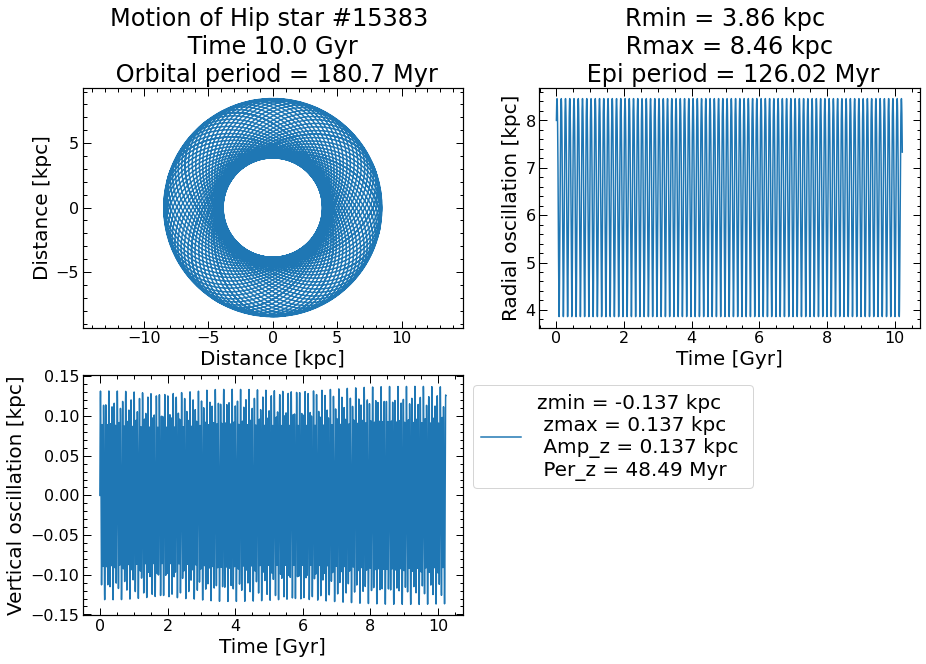

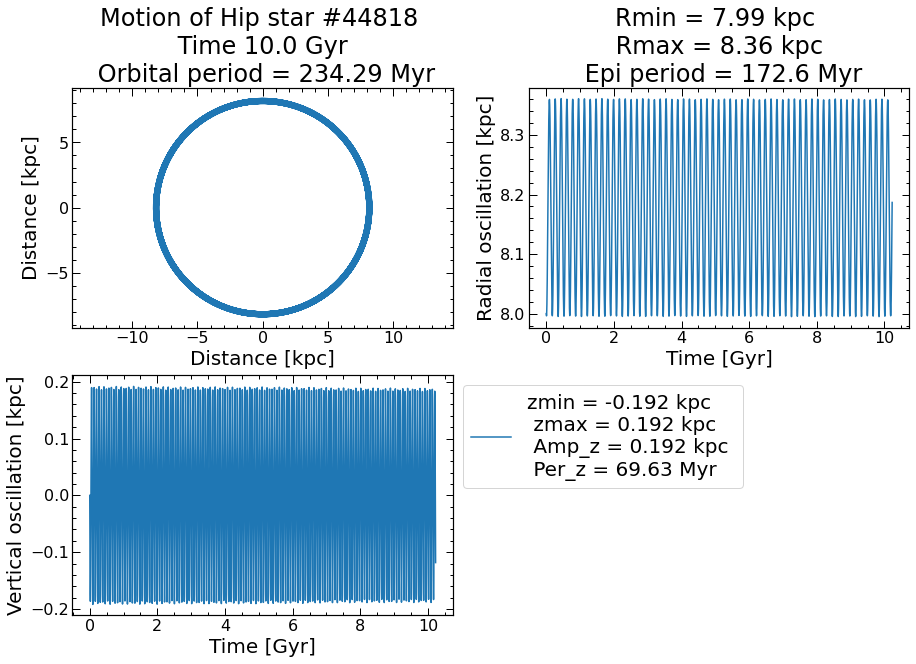

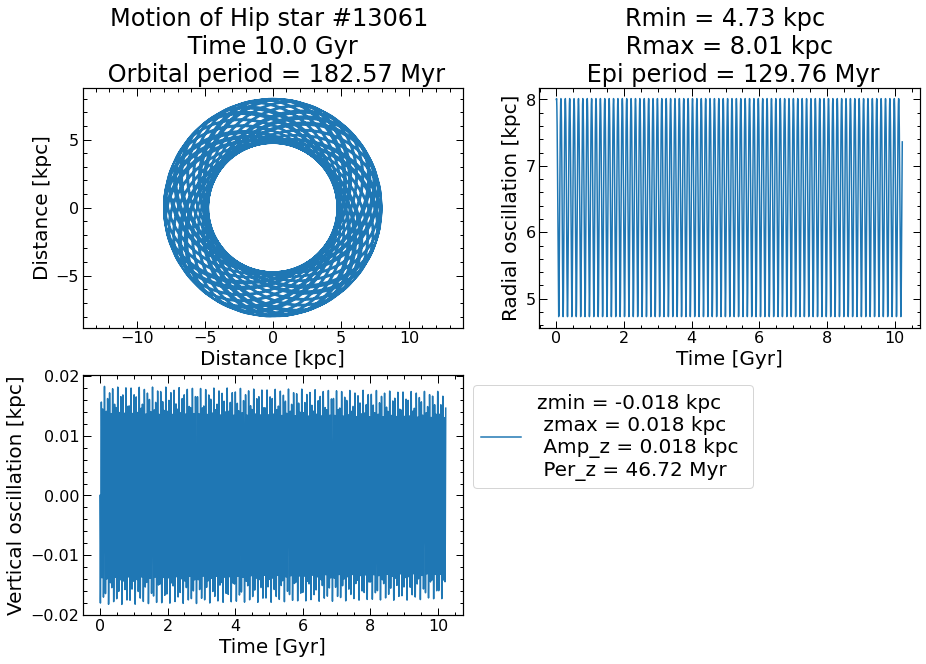

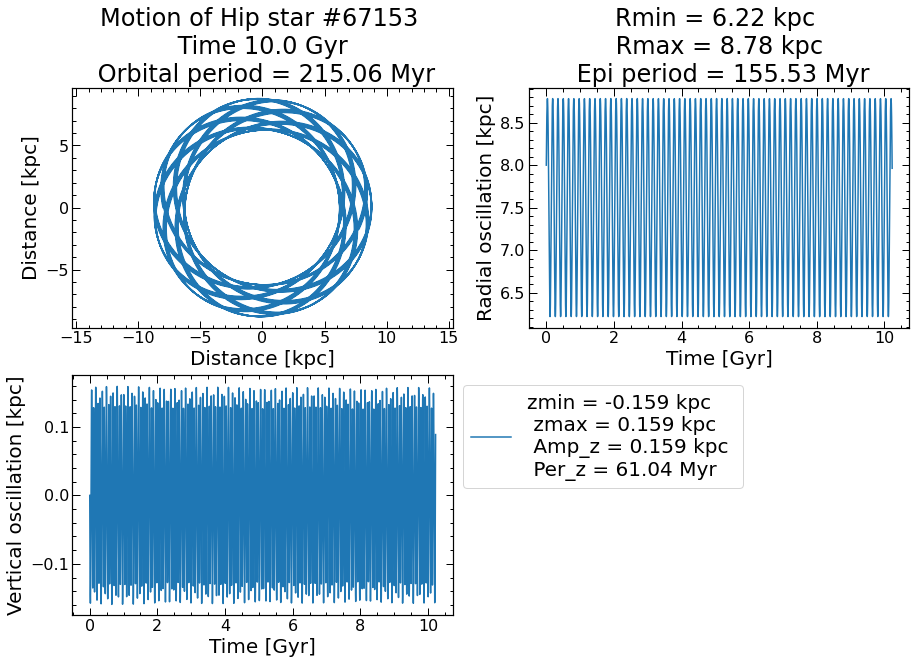

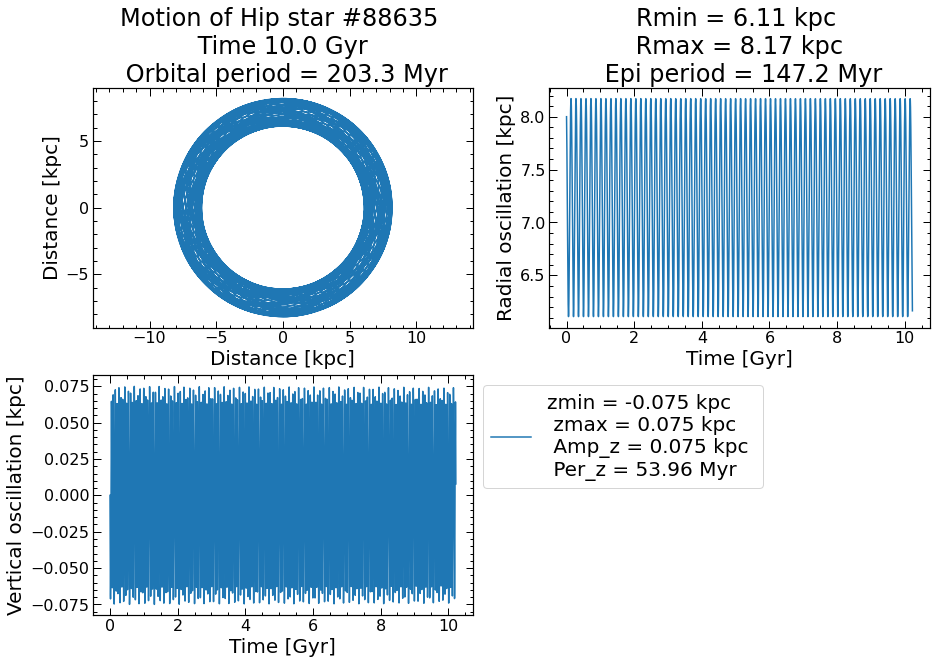

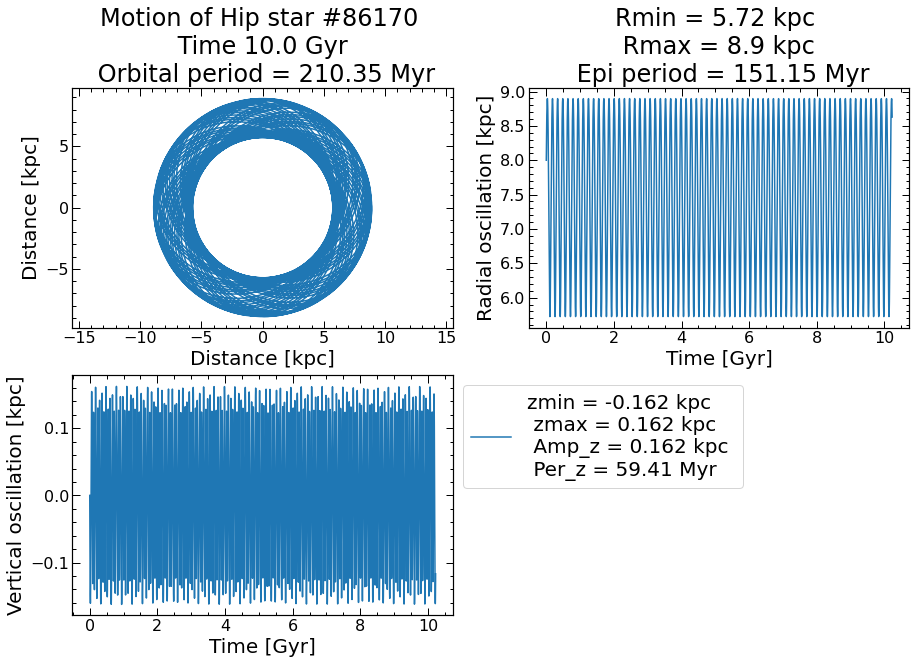

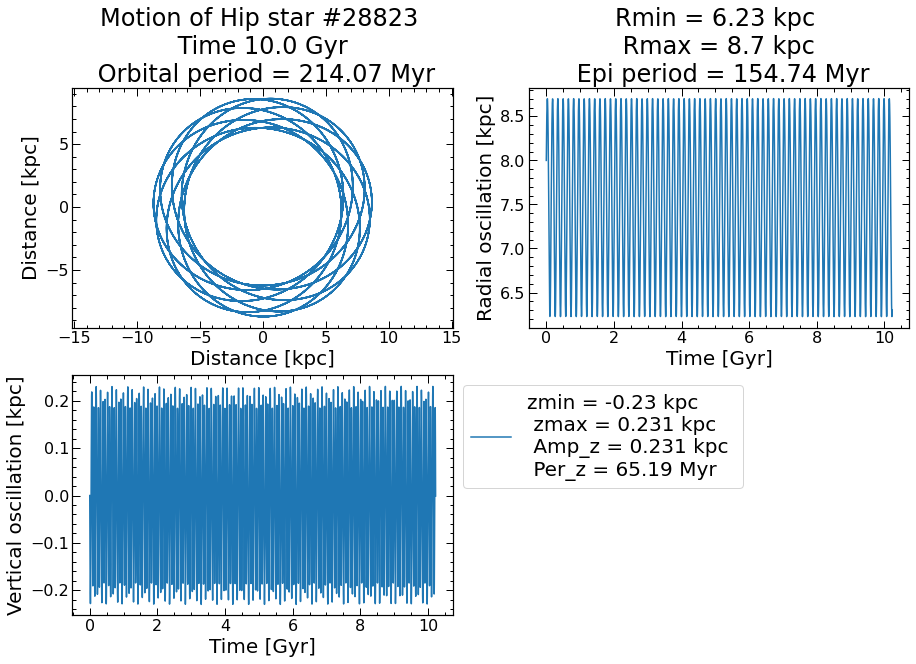

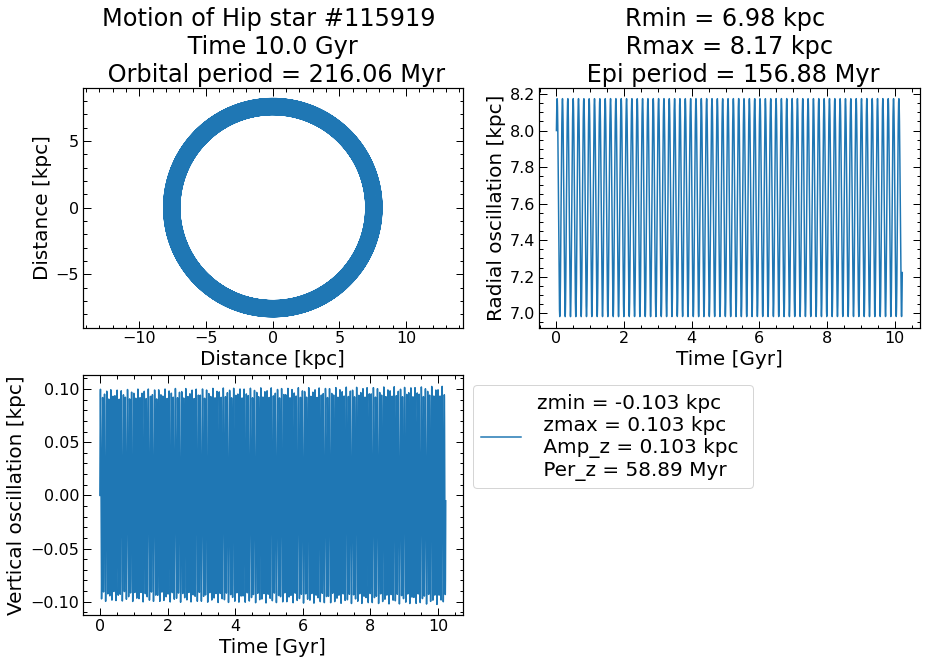

In [17]:
def calc_and_plot(sol, xdata, ydata, Rdata, zdata, star, Amp, lendata, Porb, Pepi, Pz, uvel, vvel, wvel, plot = True):
    '''A function to plot and calculate properties of the Hipparcos stars. If plot=True, the output will display
    three plots for the stars: 
    1. Their future trajectory over 10 Gyr 
    2. The radial oscillation as a function of time
    3. The vertical oscillation as a function of time
    
    The function also outputs an array consisting of the calculated values for the pericentre, apocentre,
    orbital period, epicycle period, vertical amplitude and vertical period.
    
    Parameters:
    -----------
    sol = integration output
    xdata = xvalues from integration
    ydata = yvalues -||-
    zdata = zvalues -||-
    Rdata = radial values -||-
    Amp = Vertical amplitude
    lendata = number of values put in array
    Porb = Orbital period
    Pepi = epicycle period
    Pz = Vertical period
    uvel = mean radial velocity
    vvel = mean azimuthal velocity
    wvel = mean vertical velocity
    '''
    if plot:
        fig = plt.figure(figsize = (15, 15))
        plt.subplot(321)
        plt.axis('equal')
        plt.title('Motion of Hip star #{} \n Time {} Gyr \n Orbital period = {} Myr'.format(int(star), np.around(0.0009778*t_span[1],2), np.around(Porb,2)))
        plt.xlabel('Distance [kpc]')
        plt.ylabel('Distance [kpc]')
        plt.plot(xdata/1000, ydata/1000)
        plt.subplot(322)
        plt.title('Rmin = {} kpc \n Rmax = {} kpc \n Epi period = {} Myr'.format(np.around(min(Rdata)/1000,2), np.around(max(Rdata)/1000,2), np.around(Pepi,2)))
        plt.ylabel('Radial oscillation [kpc]')
        plt.xlabel('Time [Gyr]')
        plt.plot(timelist/1000, Rdata/1000)
        plt.subplot(323)
        plt.xlabel('Time [Gyr]')
        plt.ylabel('Vertical oscillation [kpc]')
        plt.plot(timelist/1000, zdata/1000, label = 'zmin = {} kpc \n zmax = {} kpc \n Amp_z = {} kpc \n Per_z = {} Myr'.format(np.around(min(zdata)/1000,3), np.around(max(zdata)/1000,3), np.around(Amp/1000,3), np.around(Pz,2)))
        plt.legend(bbox_to_anchor=(1,1))
        
    # Create the output matrix
    Values = np.zeros((10))
    Values[0] = int(star)
    Values[1] = min(Rdata)
    Values[2] = max(Rdata)
    Values[3] = Porb
    Values[4] = Pepi
    Values[5] = Pz
    Values[6] = Amp
    Values[7] = uvel
    Values[8] = vvel
    Values[9] = wvel
    np.set_printoptions(precision = 1, suppress=True)
    return Values

for i in range(len(velocities)):
    print(calc_and_plot(solsun1[i], xlist[i], ylist[i], Rlist[i], zlist[i], velocities[i][0], zAmplitudes[i], len(velocities), new_orbs[i], Periods[i], zPeriods[i], meanu[i], meanv[i], meanw[i]))   

## Plotting various star properties as comparison to the sun

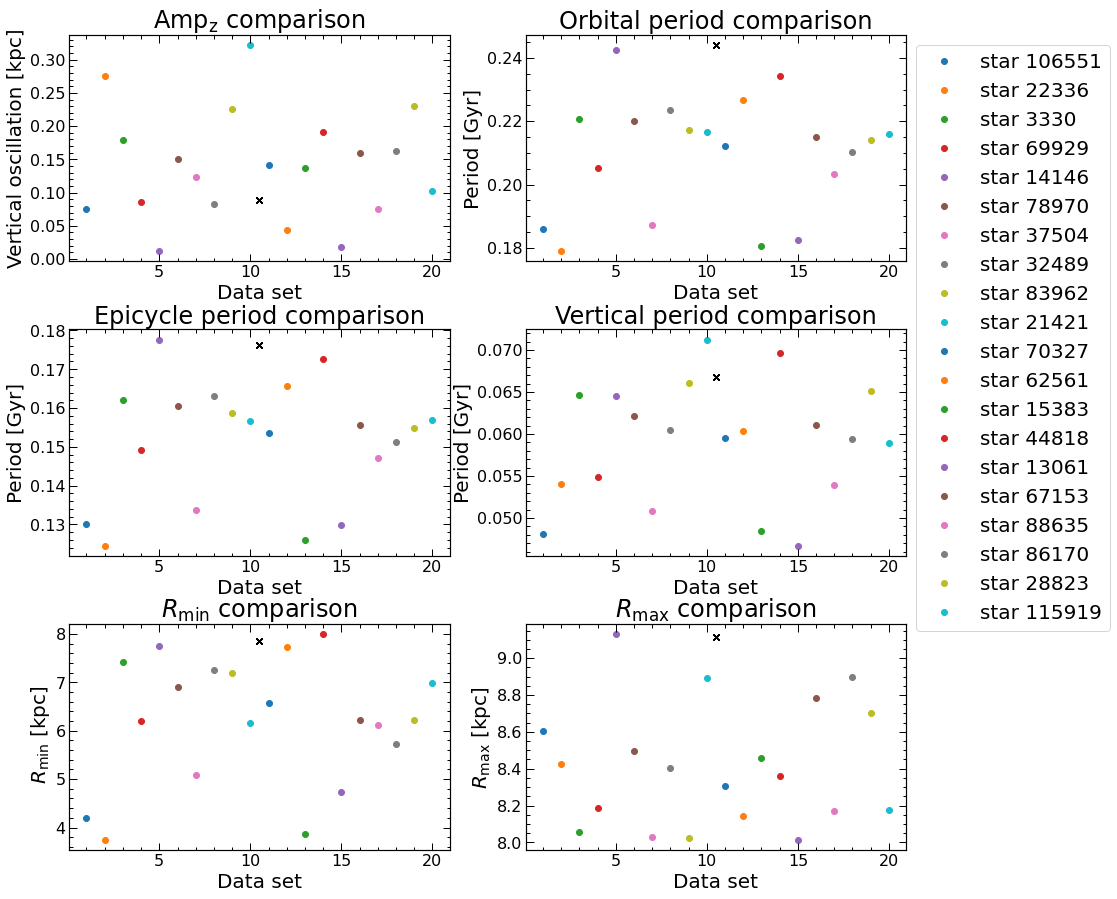

In [18]:
# Generating a point for each data set, note that the black 'x' in the plots stands for the sun
sets = np.linspace(1, len(velocities)+1, len(velocities)+1)

# plotting properties
fig = plt.figure(figsize = (15, 15))
plt.subplot(321)
for i in range(len(velocities)):
    plt.title(r'Amp$_{\rm{z}}$ comparison')
    plt.xlabel('Data set')
    plt.ylabel('Vertical oscillation [kpc]')
    plt.plot(sets[i], zAmplitudes[i]/1000, 'o')
    plt.plot(10.5, Ampz/1000, 'x', color = 'black')

plt.subplot(322)
for i in range(len(velocities)): 
    plt.title('Orbital period comparison')
    plt.xlabel('Data set')
    plt.ylabel('Period [Gyr]')
    plt.plot(sets[i], new_orbs[i]/1000, 'o', label = 'star {}'.format(int(velocities[i][0])))
    plt.plot(10.5, 0.244, 'x', color = 'black')
    plt.legend(bbox_to_anchor = (1,1))
    
plt.subplot(323)
for i in range(len(velocities)): 
    plt.title('Epicycle period comparison')
    plt.xlabel('Data set')
    plt.ylabel('Period [Gyr]')
    plt.plot(sets[i], Periods[i]/1000, 'o')
    plt.plot(10.5, tpsun/1000, 'x', color = 'black')

plt.subplot(324)
for i in range(len(velocities)): 
    plt.title('Vertical period comparison')
    plt.xlabel('Data set')
    plt.ylabel('Period [Gyr]')
    plt.plot(sets[i], zPeriods[i]/1000, 'o')
    plt.plot(10.5, Perz/1000, 'x', color = 'black')


plt.subplot(325)
for i in range(len(velocities)): 
    plt.title(r'$R_{\rm{min}}$ comparison')
    plt.xlabel('Data set')
    plt.ylabel(r' $R_{\rm{min}}$ [kpc]')
    plt.plot(sets[i], min(Rlist[i])/1000, 'o')
    plt.plot(10.5, min(rad)/1000, 'x', color = 'black')
    
plt.subplot(326)
for i in range(len(velocities)): 
    plt.title(r'$R_{\rm{max}}$ comparison')
    plt.xlabel('Data set')
    plt.ylabel(r'$R_{\rm{max}}$ [kpc]')
    plt.plot(sets[i], max(Rlist[i])/1000, 'o')
    plt.plot(10.5, max(rad)/1000, 'x', color = 'black')

fig.subplots_adjust(hspace = 0.3)
plt.savefig('prop.png', dpi = 300, bbox_inches = 'tight')
